In [1]:
import torch
import os
import random
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!git clone https://github.com/sam-single/realwaste.git
data_dir = "realwaste/RealWaste"

Cloning into 'realwaste'...
remote: Enumerating objects: 4782, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4782 (delta 4), reused 8 (delta 1), pack-reused 4764 (from 1)
Receiving objects: 100% (4782/4782), 655.92 MiB | 52.23 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4754/4754), done.


In [3]:
classes = sorted(os.listdir(data_dir))
print("Classes:", classes)

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


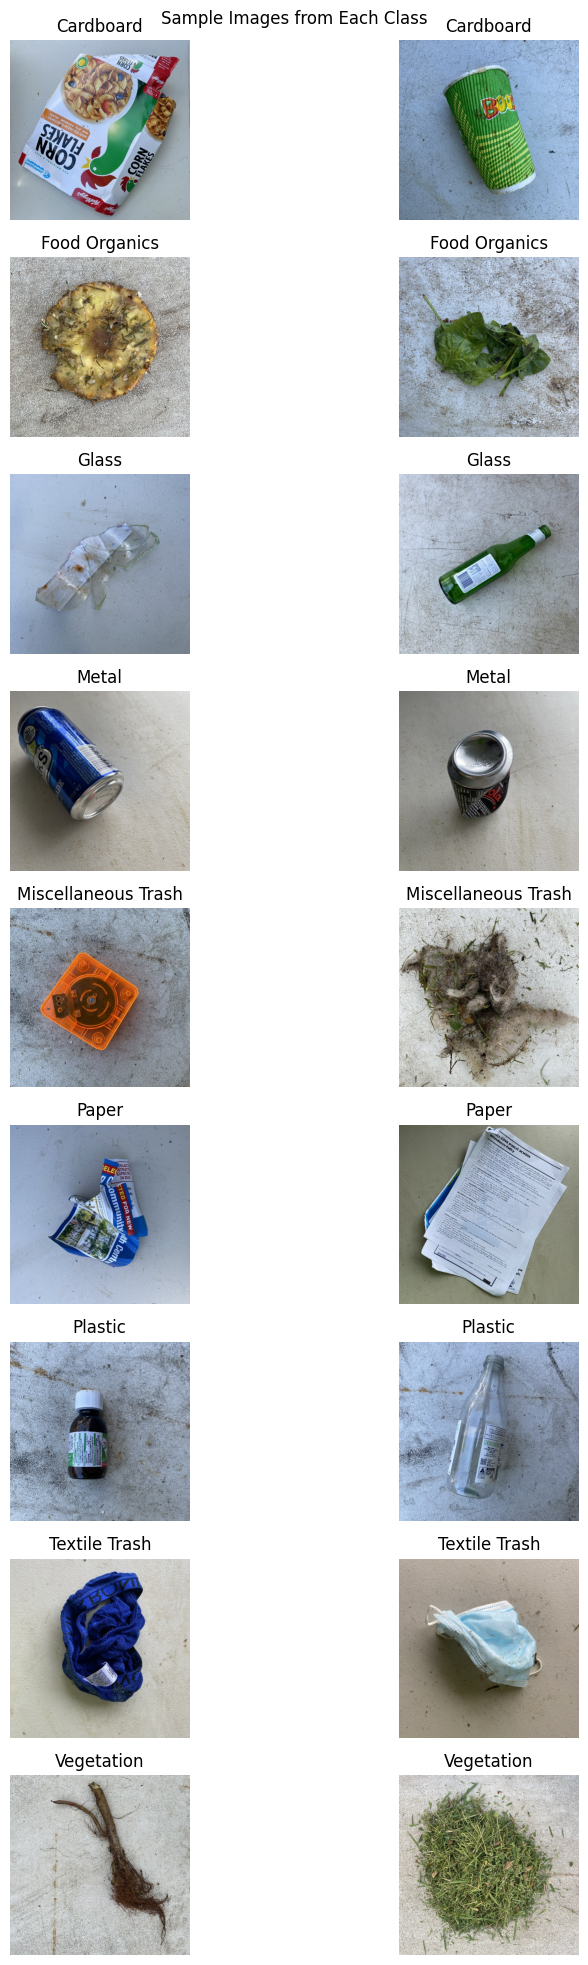

In [4]:
def visualize_images(num_per_class=2):
    fig, axs = plt.subplots(len(classes), num_per_class, figsize=(10, 20))
    fig.suptitle('Sample Images from Each Class')

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        random.shuffle(images)

        for j in range(num_per_class):
            if j < len(images):
                img_path = os.path.join(class_path, images[j])
                img = plt.imread(img_path)
                axs[i, j].imshow(img)
                axs[i, j].set_title(class_name)
                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')  # Hide if fewer images

    plt.tight_layout()
    plt.show()

# Call the function
visualize_images()

In [5]:
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, Subset

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=val_test_transforms)

# Split dataset
total_size = len(dataset)
train_size = int(0.7 * total_size)  # ~3324 images
val_size = int(0.15 * total_size)   # ~713 images
test_size = total_size - train_size - val_size  # ~715 images

indices = list(range(total_size))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Apply training transforms to train_dataset
train_dataset.dataset.transform = train_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 3326, Val size: 712, Test size: 714


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.relu5 = nn.ReLU()

        self.dropout = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.bn4(self.fc1(x))
        x = self.relu4(x)
        x = self.bn5(self.fc2(x))
        x = self.relu5(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize model
model = SimpleCNN(num_classes=len(classes)).cuda() if torch.cuda.is_available() else SimpleCNN(num_classes=len(classes))

Epoch 1/20, Train Loss: 0.5406, Val Loss: 0.7475, Train Acc: 81.06%, Val Acc: 74.44%
Epoch 2/20, Train Loss: 0.4939, Val Loss: 0.6451, Train Acc: 82.71%, Val Acc: 78.51%
Epoch 3/20, Train Loss: 0.4974, Val Loss: 0.6693, Train Acc: 82.26%, Val Acc: 77.81%
Epoch 4/20, Train Loss: 0.4463, Val Loss: 0.7029, Train Acc: 84.79%, Val Acc: 76.40%
Epoch 5/20, Train Loss: 0.4502, Val Loss: 0.9238, Train Acc: 84.22%, Val Acc: 70.79%
Epoch 6/20, Train Loss: 0.3800, Val Loss: 0.7130, Train Acc: 86.44%, Val Acc: 76.40%
Epoch 7/20, Train Loss: 0.3439, Val Loss: 0.7866, Train Acc: 88.30%, Val Acc: 74.30%
Epoch 8/20, Train Loss: 0.3128, Val Loss: 0.6087, Train Acc: 89.33%, Val Acc: 80.20%
Epoch 9/20, Train Loss: 0.2960, Val Loss: 0.6470, Train Acc: 90.20%, Val Acc: 78.79%
Epoch 10/20, Train Loss: 0.2901, Val Loss: 0.7443, Train Acc: 90.56%, Val Acc: 78.23%
Epoch 11/20, Train Loss: 0.2736, Val Loss: 0.6168, Train Acc: 90.86%, Val Acc: 79.21%
Epoch 12/20, Train Loss: 0.2476, Val Loss: 0.5757, Train Acc: 9

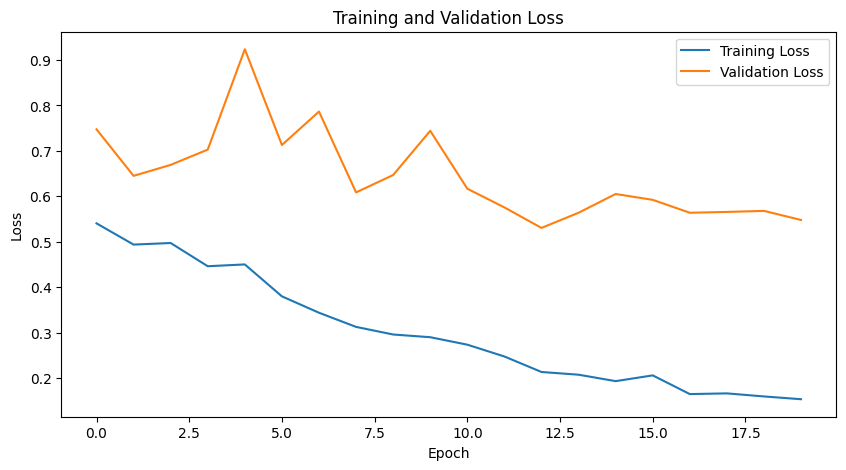

In [12]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to appropriate device

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to device
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

        if scheduler:
            scheduler.step(val_losses[-1])

    return train_losses, val_losses, train_accuracies, val_accuracies

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Define scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Train
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()